In [1]:
import galarp as grp
from galarp import InterpolatedWind, InterpolatedDensity

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter

In [2]:
orbits = grp.OrbitContainer.load("temp/orbits_JZ_dup.grp")

print(orbits)

In [3]:
times, rstrips = grp.rstrip(orbits)

r_final = grp.final_rstrip(orbits)


In [4]:
grp.rstrip_plot(orbits, title="Stripping Radius", rstrip_frac=0.8, zmax=2 * u.kpc, rmax=20 * u.kpc, 
            outname="figures/stripping_radius_JZ.pdf", close_plot=True)

/Users/hsouchereau/galarp/galarp/postprocessing/plotting/general_plots.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


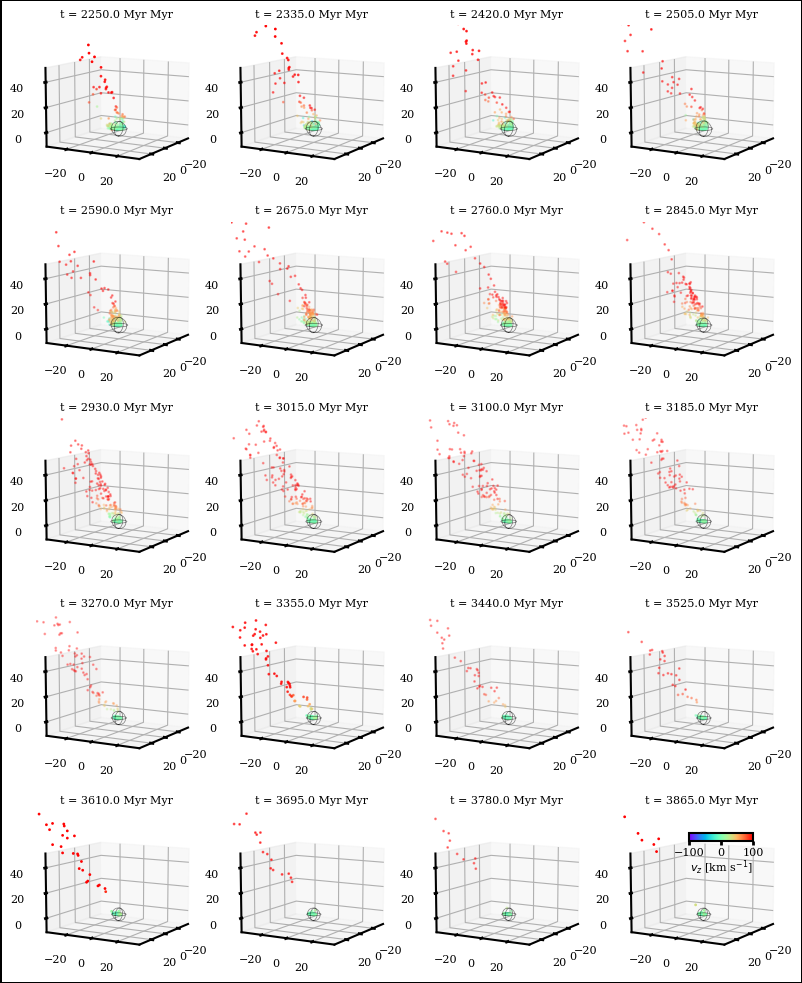

In [5]:
grp.pyplot_3D_plot(orbits, nrows=5, ncols=4, tmin=450, tmax=800, cmap="rainbow", rmax=35, outname="figures/orbits_3D_JZ.pdf", dpi=50)


In [6]:
x,y,z, *_ = grp.get_orbit_data(orbits.data)
x,y,z = x.T, y.T, z.T


In [7]:
def calculate_rstrip(xyz, rmax=20, zmax=2, frac=0.8):
    x,y,z = xyz
    r = np.sqrt(x**2 + y**2 + z**2)
    this_r_cut = r[np.abs(z) < zmax]
    this_r_cut = this_r_cut[this_r_cut < rmax]
    
    try:
        cdf = stats.ecdf(this_r_cut)
        cdf_xs, cdf_vals = cdf.cdf.quantiles, cdf.cdf.probabilities
        return cdf_xs[np.argmin(np.abs(cdf_vals - frac))]
    except:
        return 0

this_x, this_y, this_z = x[0], y[0], z[0]

#%timeit 
calculate_rstrip([this_x, this_y, this_z])

5.716354371064774

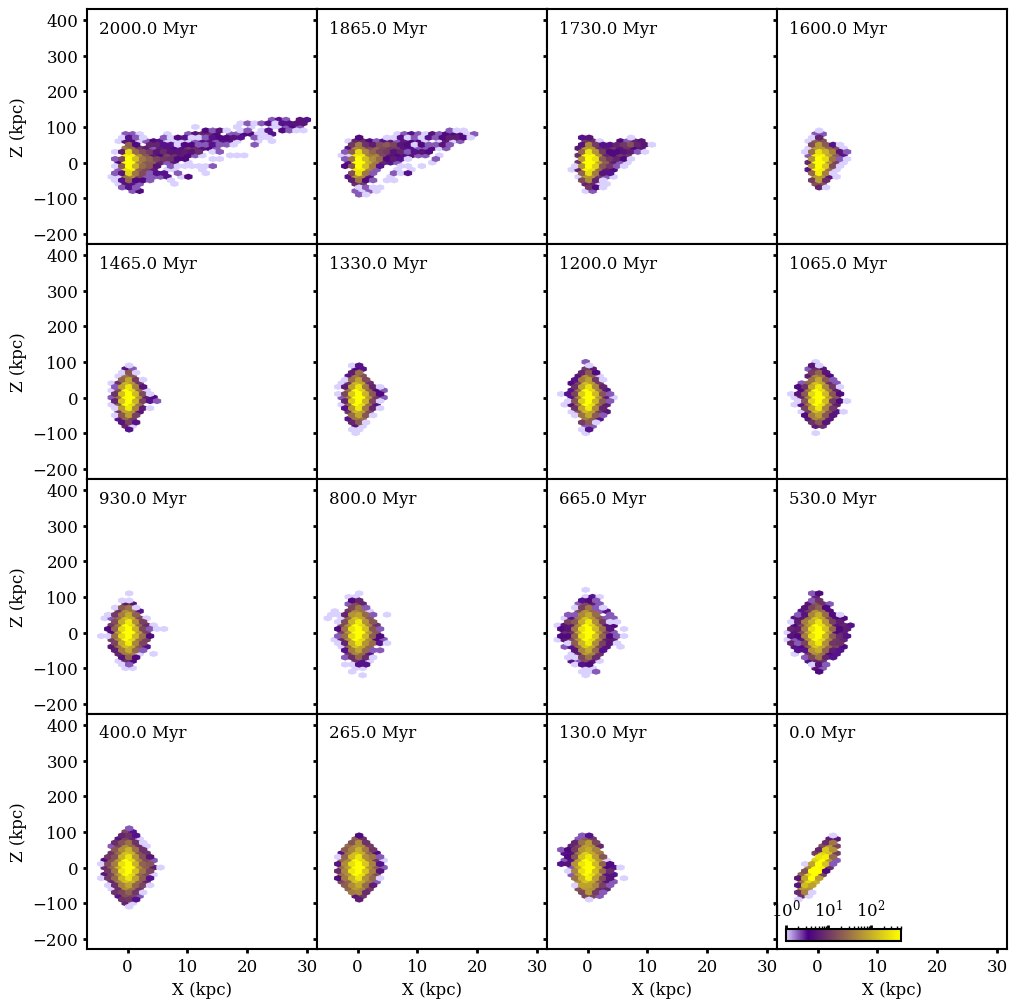

In [8]:
times = np.linspace(400, len(orbits.data.t) - 1000, 4 * 4).astype(int)

grp.density_matrix(orbits, cmap=cmap, x_ind=2, y_ind=5, ylabel='Z (kpc)', times=times,
                   yextent=(-200, 400), xextent=(-5, 30), outname="figures/density_matrix_JZ_dup_xz.png")

In [9]:
print((1 / orbits.metadata["R_CLOUD"] **3 * orbits.metadata["M_CLOUD"]).to(u.g / u.cm**3))
print()


5.414324258597863e-23 g / cm3



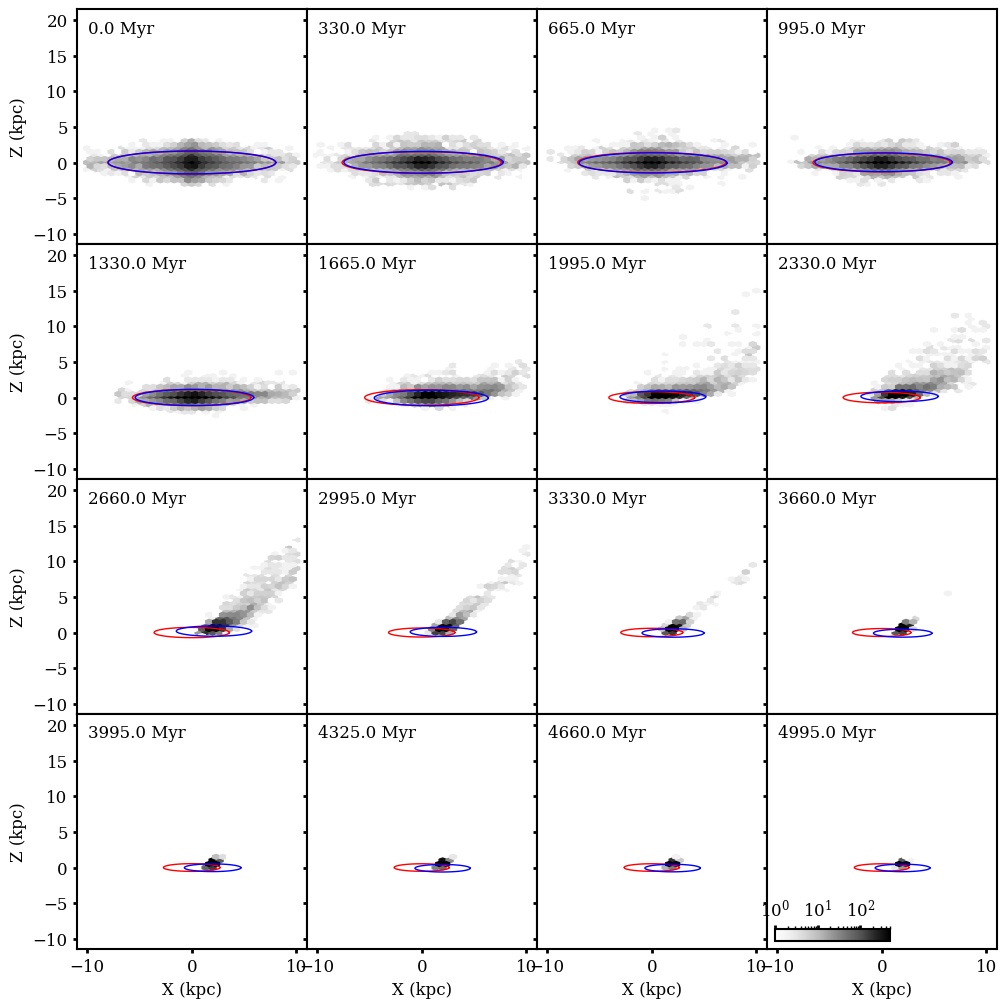

In [10]:

grp.rstrip_check(orbits, xextent=(-10, 10), yextent=(-10,20), cmap="Greys", outname="figures/shadow_check.pdf")

In [11]:
def create_youtube_description(orbits):
    potential = orbits.metadata["POTENTIAL"]
    md = orbits.metadata
    wind = orbits.metadata["WIND"]
    shadow = orbits.metadata["SHADOW"]

    desc = f'This is a simulation of particle evolution in a {potential} with {potential.mass_enclosed([0,0,100] * u.kpc)[0] :.2e}\n'
    desc += f'The particles are clouds with masses of {md["M_CLOUD"]} and radii of {md["R_CLOUD"]}.\n'
    desc += f'The cloud orbits are integrated for {orbits.data.t[-1]} at time steps of {md["DT"]}\n'
    desc += f'\n'
    desc += f'Ram Pressure Wind: {wind}\n'
    desc += f'Ram Pressure Shadow: {shadow}, Dynamic: {shadow.dynamic_shadow}\n'
    

    print(desc)

create_youtube_description(orbits)

This is a simulation of particle evolution in a CompositePotential with 2.79e+11 solMass
The particles are clouds with masses of 100000.0 solMass and radii of 50.0 pc.
The cloud orbits are integrated for 4995.0 Myr at time steps of 5.0 Myr

Ram Pressure Wind: <RP Wind Vector=[0. 0. 0.] km / s  Inclination=0.00  >
Ram Pressure Shadow: <Uniform RP Shadow:  Phi=45.00  Damping=0.4  R_Disk=8.0  zmin=0.5 >, Dynamic: False



MovieWriter ffmpeg unavailable; using Pillow instead.


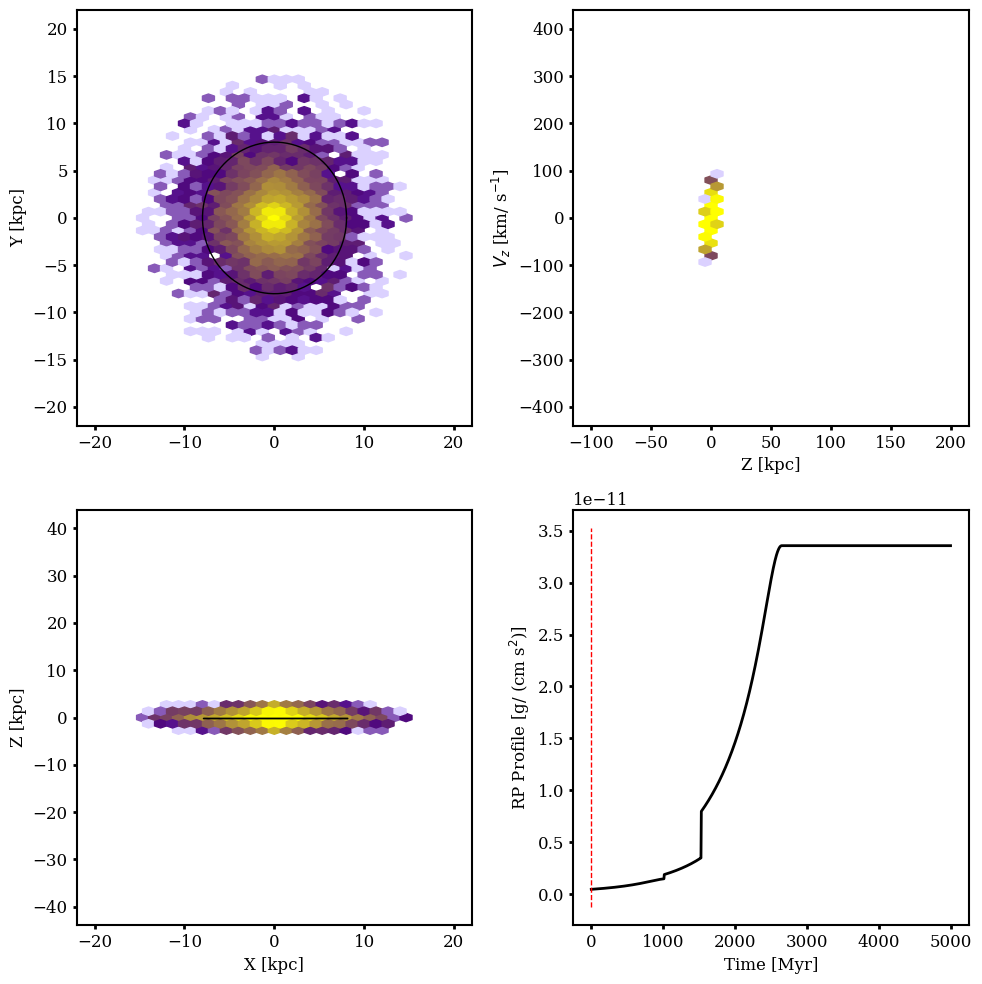

In [22]:
def animated_hexbin_plot(orbits, x_ind=1, y_ind=2, n_frames=100, **kwargs):
    
    outname = kwargs.get("outname", "animated_hexbin.gif")
    cmap = kwargs.get("cmap", "viridis")

    figsize = kwargs.get("figsize", (10, 10))

    gridsize = kwargs.get("gridsize", 30)
    xextent = kwargs.get("xextent", (-40., 40.))
    xextent = (-xextent, xextent) if isinstance(xextent, (int, float)) else xextent
    yextent = kwargs.get("yextent", (-40., 40.))
    yextent = (-yextent, yextent) if isinstance(yextent, (int, float)) else yextent
    vextent = kwargs.get("vextent", (-100, 300))
    vextent = (-vextent, vextent) if isinstance(vextent, (int, float)) else vextent

    dx, dy = xextent[1] - xextent[0], yextent[1] - yextent[0]

    hlines, vlines = kwargs.get("hlines", []), kwargs.get("vlines", [])

    cbar_loc = kwargs.get("cbar_loc", "lower left")

    vmin, vmax = kwargs.get("vmin", 1), kwargs.get("vmax", 500)

    def add_labels(ax):
        ax[1][0].set_xlabel("X [kpc]")
        ax[0][0].set_ylabel("Y [kpc]")
        ax[1][0].set_ylabel("Z [kpc]")
        ax[0][1].set_xlabel("Z [kpc]")
        ax[0][1].set_ylabel(r"$V_z$ [km/ s$^{-1}$]")
        ax[1][1].set_xlabel("Time [Myr]")
        ax[1][1].set_ylabel(r"RP Profile [g/ (cm s$^2$)]")

    
    fig, ax = plt.subplots(2, 2, facecolor="white", figsize=figsize)

    frames = np.linspace(0, len(orbits.data.t) - 1, n_frames).astype(int)

    x,y,z,vx,vy,vz =grp.get_orbit_data(orbits.data)
    x,y,z,vx,vy,vz = x.T, y.T, z.T, vx.T, vy.T, vz.T

    

    wind = orbits.metadata["WIND"]
    density = orbits.metadata["RHO_ICM"]

    wind_profile = np.sqrt(np.sum(orbits.metadata["WIND"].evaluate_arr(orbits.data.t) ** 2, axis=1)) * u.kpc/u.Myr
    wind_profile = wind_profile.to(u.cm/u.s)

    dens_profile = orbits.metadata["RHO_ICM"].evaluate_arr(orbits.data.t) * (u.g / u.cm**3)
    rp_profile = wind_profile ** 2 * dens_profile
    
    
    hb1 = ax[0][0].hexbin(x[0], y[0], bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[xextent[0], xextent[1], xextent[0], xextent[1]], 
                        vmin=vmin, vmax=vmax, zorder = 5)
    hb2 = ax[1][0].hexbin(x[0], z[0], bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[xextent[0], xextent[1], yextent[0], yextent[1]], 
                        vmin=vmin, vmax=vmax, zorder = 5)
    hb3 = ax[0][1].hexbin(z[0], vz[0], bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[vextent[0], vextent[1], -400, 400], 
                        vmin=vmin, vmax=vmax, zorder = 5)
    
    ax[1][1].plot(orbits.data.t, rp_profile, color="black", lw=2)
    
    add_labels(ax)

    plt.tight_layout()

    
    def animate(i):
        this_x, this_y, this_z = x[i], y[i], z[i]
        rstrip = grp.calculate_rstrip([this_x, this_y, this_z], frac=0.9)

        ell = grp.ellipse_coords(np.median(this_x), 0, rstrip, rstrip, 0, 100)

        for axis in ax.flatten()[:]:
            axis.cla()

        hb1 = ax[0][0].hexbin(x[i], y[i], bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[xextent[0], xextent[1], xextent[0], xextent[1]], 
                        vmin=vmin, vmax=vmax, zorder = 5)
        
        
        hb2 = ax[1][0].hexbin(x[i], z[i], bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[xextent[0], xextent[1], yextent[0], yextent[1]], 
                        vmin=vmin, vmax=vmax, zorder = 5)
        hb3 = ax[0][1].hexbin(z[i], vz[i], bins="log", cmap=cmap, gridsize=(gridsize, gridsize),
                        extent=[vextent[0], vextent[1], -400, 400], 
                        vmin=vmin, vmax=vmax, zorder = 5)
        xlims, ylims = ax[0][0].get_xlim(), ax[0][0].get_ylim()
        dx, dy = xlims[1] - xlims[0], ylims[1] - ylims[0]



        ax[0][0].plot(ell[0], ell[1], color="black", zorder=6)
        ax[1][0].plot(ell[0], ell[2], color="black", zorder=6)

        ax[1][1].plot(orbits.data.t, rp_profile, color="black", lw=2)

        current_time = orbits.data.t[i].value
        ylims = ax[1][1].get_ylim()
        ax[1][1].plot([current_time, current_time], [ylims[0], ylims[1]], color="red", lw=1, ls="dashed")

        add_labels(ax)

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
    ani.save(outname, writer='ffmpeg', fps=24)

animated_hexbin_plot(orbits, outname="figures/animated_hexbin_JZ.gif", n_frames=200, cmap=cmap, xextent=20, 
                     vextent=(-100, 200))